<a href="https://colab.research.google.com/github/paviayyala/AIML-Lab/blob/main/GANs_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1 . **Transformer** (MiniChatGPT) (toy next-token prediction)

The tiny Transformer learns simple language patterns by taking a short sequence of words as input and predicting the next word as output using self-attention.

The Very Tiny Transformer is solving a next-word prediction problem.
It takes a small sequence of words as input and learns the pattern of language in those sentences.
Each input word is converted into a numeric token and then into an embedding.
The Transformer uses self-attention to understand relationships between the words.
Its output is the most likely next word that should follow the input sequence.
This is a miniature version of how large language models like GPT learn to generate text.



Toy dataset built from a few sentences (no external download).

Tiny embedding + TransformerEncoder layer to predict next token.

Great to show how token → embedding → transformer → logits → loss works.

In [ ]:
# Very Tiny Transformer (PyTorch) — Beginner friendly toy LM
# Paste this whole block into Colab and run (GPU optional)

!pip install -q torch tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import math
from tqdm import tqdm
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

# ---- Tiny toy dataset (no download) ----
# A few short sentences to learn basic sequences
sentences = [
    "hello world",
    "how are you",
    "hello there",
    "how is it going",
    "i am fine",
    "world hello",
    "are you fine",
]

# Build simple word-level vocab
tokens = set()
for s in sentences:
    for w in s.split():
        tokens.add(w)
tokens = sorted(list(tokens))
itos = ['<pad>','<unk>'] + tokens
stoi = {w:i for i,w in enumerate(itos)}
pad_idx = stoi['<pad>']
unk_idx = stoi['<unk>']

# Convert sentences to token id lists
def encode(s):
    return [stoi.get(w, unk_idx) for w in s.split()]

# Create dataset of input->next token sequences (teacher forcing)
class ToyDataset(Dataset):
    def __init__(self, sents, seq_len=4):
        self.seq_len = seq_len
        seqs = []
        for s in sents:
            ids = encode(s)
            # pad or trim to seq_len+1 so we have inputs and targets
            ids = ids[:seq_len+1]
            if len(ids) < seq_len+1:
                ids = ids + [pad_idx] * (seq_len+1 - len(ids))
            seqs.append(ids)
        self.data = seqs
    def __len__(self): return len(self.data)
    def __getitem__(self, i):
        arr = torch.tensor(self.data[i], dtype=torch.long)
        return arr[:-1], arr[1:]  # input tokens, target next tokens

seq_len = 4
ds = ToyDataset(sentences, seq_len)
loader = DataLoader(ds, batch_size=4, shuffle=True)

vocab_size = len(itos)

# ---- Very small Transformer model ----
class TinyPosEnc(nn.Module):
    def __init__(self, d_model, max_len=50):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(pos * div)
        pe[:, 1::2] = torch.cos(pos * div)
        self.register_buffer('pe', pe.unsqueeze(0))  # (1, max_len, d_model)
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class TinyTransformerLM(nn.Module):
    def __init__(self, vocab_size, d_model=32, nhead=4, num_layers=1):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, d_model, padding_idx=pad_idx)
        self.pos = TinyPosEnc(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward=64)
        self.trans_enc = nn.TransformerEncoder(encoder_layer, num_layers)
        self.fc = nn.Linear(d_model, vocab_size)
    def forward(self, x):
        # x: (batch, seq_len)
        x = self.emb(x) * math.sqrt(self.emb.embedding_dim)   # (batch, seq_len, d_model)
        x = self.pos(x)
        x = x.permute(1,0,2)  # Transformer expects (seq_len, batch, d_model)
        x = self.trans_enc(x)
        x = x.permute(1,0,2)  # back to (batch, seq_len, d_model)
        return self.fc(x)     # (batch, seq_len, vocab)

model = TinyTransformerLM(vocab_size).to(device)
print(model)

# ---- Training ----
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
optimiser = optim.Adam(model.parameters(), lr=5e-4)

n_epochs = 30  # small; you will see training quickly on tiny data
for epoch in range(1, n_epochs+1):
    model.train()
    total_loss = 0.0
    for src, tgt in loader:
        src = src.to(device)
        tgt = tgt.to(device)
        optimiser.zero_grad()
        logits = model(src)                # (batch, seq_len, vocab)
        loss = criterion(logits.view(-1, logits.size(-1)), tgt.view(-1))
        loss.backward()
        optimiser.step()
        total_loss += loss.item()
    if epoch % 5 == 0 or epoch == 1:
        print(f"Epoch {epoch:2d} | Loss: {total_loss/len(loader):.4f}")

# ---- Quick inference: greedy next-token generation ----
model.eval()
def generate(seed, max_steps=5):
    # seed: string of words
    ids = [stoi.get(w, unk_idx) for w in seed.split()]
    for _ in range(max_steps):
        inp = ids[-seq_len:]
        if len(inp) < seq_len:
            inp = [pad_idx] * (seq_len - len(inp)) + inp
        tensor = torch.tensor([inp], dtype=torch.long).to(device)
        with torch.no_grad():
            logits = model(tensor)
            next_id = torch.argmax(logits[0, -1]).item()
        ids.append(next_id)
        # stop if pad token predicted
        if next_id == pad_idx: break
    return " ".join([itos[i] for i in ids if i != pad_idx])

# Try a few seeds
print("Vocab:", itos)
print("Gen from 'hello':", generate("hello", max_steps=4))
print("Gen from 'how':", generate("how", max_steps=4))


Running on: cpu
TinyTransformerLM(
  (emb): Embedding(14, 32, padding_idx=0)
  (pos): TinyPosEnc()
  (trans_enc): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (linear1): Linear(in_features=32, out_features=64, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=64, out_features=32, bias=True)
        (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=32, out_features=14, bias=True)
)
Epoch  1 | Loss: 3.1479
Epoch  5 | Loss: 2.8538
Epoch 10 | Loss: 2.6726
Epoch 15 | Loss: 2.3691
Epoch 20 | Loss: 2.0081
Epoch 25 | Loss: 1.8089
Epo

## **Simple GAN based Model (using MNIST dataset and PyTorch)**

Train a generative model that can produce realistic-looking handwritten digit images (0–9) similar to the MNIST dataset.
Goal: learn the distribution of MNIST digits so the generator can turn random noise into digit images that a discriminator has difficulty distinguishing from real MNIST samples.

2) How it works (high-level)

Two networks (adversarial training):

Generator (G): maps a random noise vector (latent vector z) → image (28×28 grayscale). Its goal is to produce images that look real.

Discriminator (D): maps an image → scalar logit (real vs fake). Its goal is to correctly classify real images as real and generated images as fake.

Adversarial objective (minimax):

D is trained to maximize log(D(x)) + log(1 − D(G(z))).

G is trained to maximize log(D(G(z))) (or equivalently to minimize log(1 − D(G(z))) or use BCEWithLogits with flipped labels).

Training loop:

For each mini-batch: update D using both real images and current generator outputs; then update G to fool D.

Over time, G improves image realism; D improves discrimination. A balance is needed to avoid mode collapse or D dominating.

3) Dataset

MNIST: 60k training grayscale images of size 28×28 of digits 0–9. Preprocessing: convert to tensor and normalize to range [-1, 1] (if generator outputs tanh) or [0,1] depending on architecture.

Small experiments: train on a subset or use the full training set; batching (e.g., 64–128) is typical.

4) How to test (practical tests you run during/after training)

Visual inspection: save a grid of generated samples each epoch using fixed noise vector → observe progression of quality. This is the most direct test for GANs.

Discriminator loss / Generator loss curves: monitor trends (not absolute values). Instability or oscillation suggests hyperparameter tuning.

Inception-like score (toy alternatives): for MNIST you can use a pre-trained digit classifier to evaluate:

Classifier accuracy on generated samples: generate many images, run a pre-trained MNIST classifier, measure top predicted digit distribution (should be diverse across classes).

Frechet Inception Distance (FID): adapted to MNIST using a small embedding network; measures distance between real and generated distributions (lower is better).

Diversity checks: ensure generator outputs cover all digit classes (no collapse to a few modes).

Latent interpolation: linearly interpolate between two noise vectors and visualize outputs to see smooth transitions (checks representation continuity).

5) Validate (procedures to confirm model quality & robustness)

Holdout set for qualitative evaluation: keep a small set of real MNIST images not used in training for visual comparison.

Multiple seeds & runs: re-run training with different random seeds to ensure results are not a lucky run.

Overfitting check: if G reproduces exact training images, inspect nearest-neighbor comparisons between generated images and training set (should resemble distribution but not memorize).

Ablation tests: modify architecture/hyperparameters (latent dim, learning rates, batch size, optimizer betas) and confirm consistent behavior.

Robustness to hyperparameters: test with variations (e.g., lower/higher learning rates) to find stable training regimes.

Quantitative metrics: compute FID or accuracy of the classifier on generated samples periodically; track improvement over epochs.

6) Summary (short)

A Simple GAN for MNIST pairs a tiny generator and discriminator trained adversarially to produce realistic 28×28 digit images from random noise. Evaluate primarily with visual samples, supported by classifier-based metrics and diversity/FID checks. Watch for instability—use small architectures, conservative learning rates, and visual monitoring to keep training educational and tractable on Colab.

Device: cpu


100%|██████████| 9.91M/9.91M [00:00<00:00, 40.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.26MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.49MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.1MB/s]
Epoch 1/10:   0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 1/10: 100%|██████████| 469/469 [05:34<00:00,  1.40it/s, lossD=0.323, lossG=1.89]


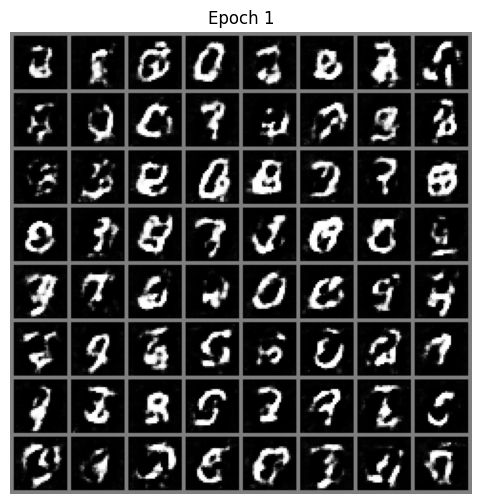

Epoch 2/10: 100%|██████████| 469/469 [05:36<00:00,  1.39it/s, lossD=0.226, lossG=1.95]


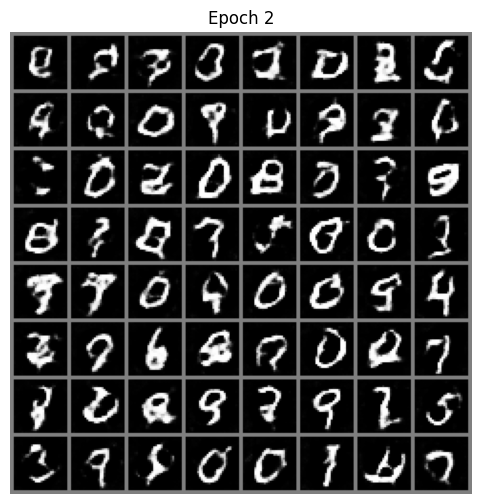

Epoch 3/10: 100%|██████████| 469/469 [05:34<00:00,  1.40it/s, lossD=0.253, lossG=1.66]


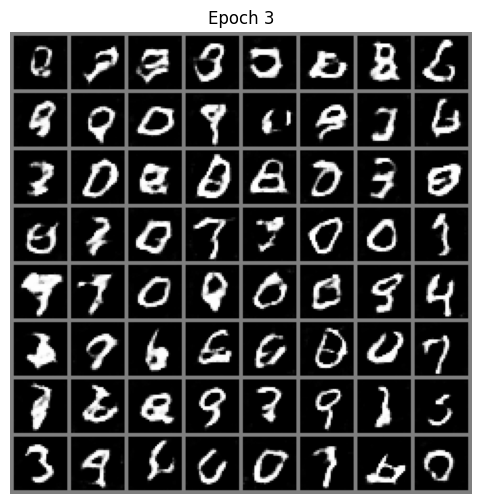

Epoch 4/10: 100%|██████████| 469/469 [05:34<00:00,  1.40it/s, lossD=0.285, lossG=1.93]


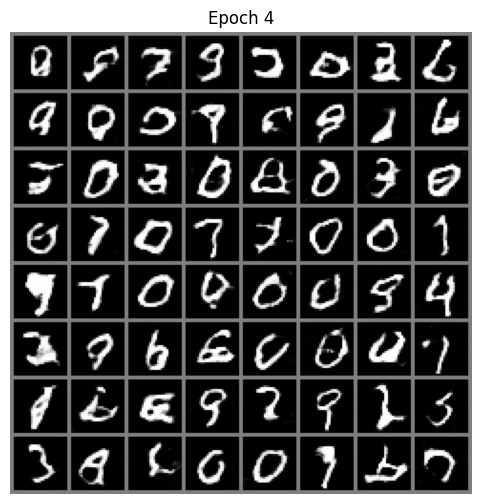

Epoch 5/10: 100%|██████████| 469/469 [05:38<00:00,  1.39it/s, lossD=0.343, lossG=1.08]


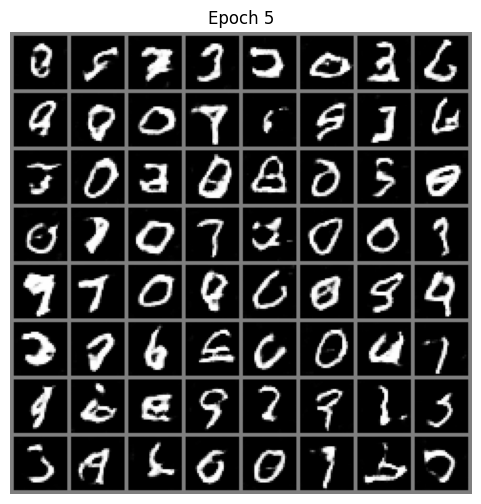

Epoch 6/10: 100%|██████████| 469/469 [05:32<00:00,  1.41it/s, lossD=0.26, lossG=1.01]


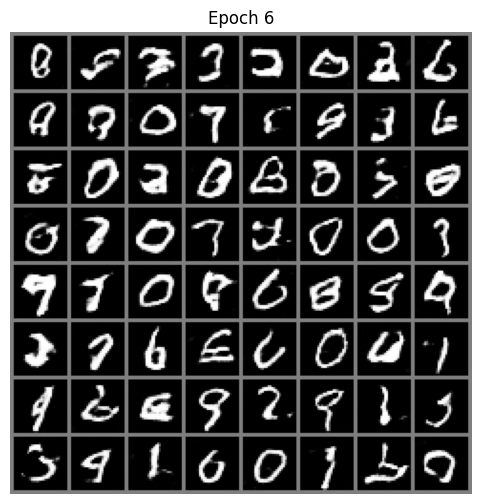

Epoch 7/10: 100%|██████████| 469/469 [05:37<00:00,  1.39it/s, lossD=0.276, lossG=2.1]


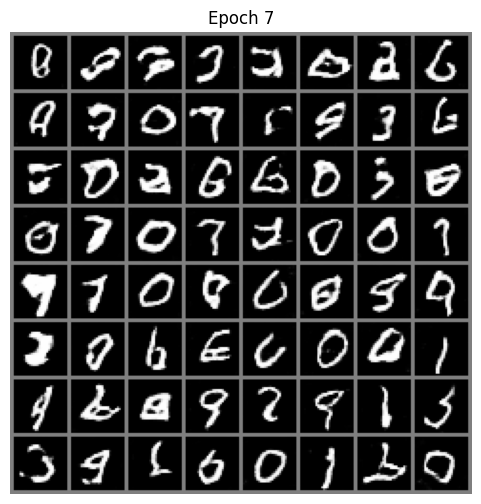

Epoch 8/10: 100%|██████████| 469/469 [05:50<00:00,  1.34it/s, lossD=0.768, lossG=4.92]


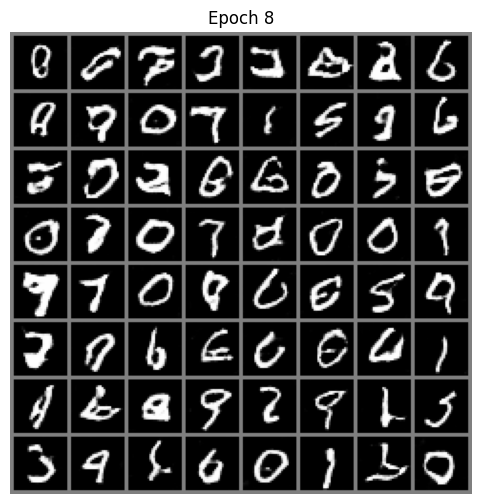

Epoch 9/10: 100%|██████████| 469/469 [05:33<00:00,  1.40it/s, lossD=0.316, lossG=1.8]


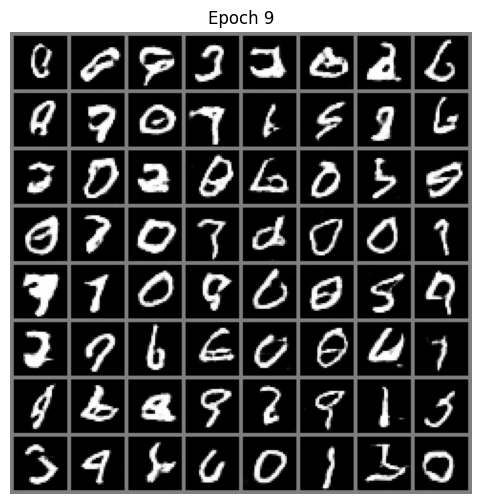

Epoch 10/10: 100%|██████████| 469/469 [05:39<00:00,  1.38it/s, lossD=0.324, lossG=0.904]


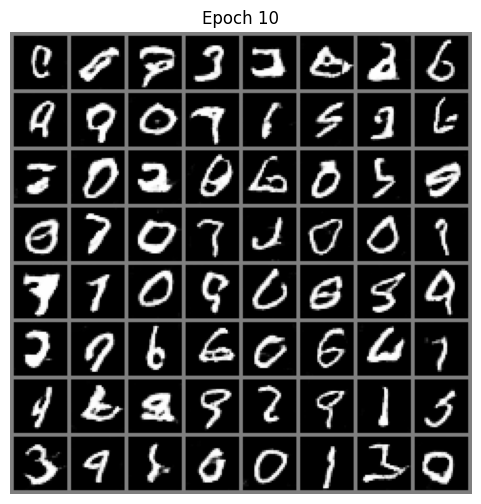

Training finished. Samples saved to gan_samples


In [ ]:
# Colab: Simple GAN on MNIST (PyTorch)
# ----------------------------------------------------------
# 1) Run on GPU (Runtime -> Change runtime type -> GPU)
# 2) This is an educational, minimal DCGAN-style architecture.
# 3) Copy each cell into Colab as separate cells.

# Cell 1: Install & imports
!pip install -q torch torchvision tqdm matplotlib
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# Ensure reproducibility (to some extent)
torch.manual_seed(42)

# Cell 2: Hyperparams and device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

latent_dim = 100           # size of the random noise vector (z)
batch_size = 128
lr = 2e-4                  # learning rate
n_epochs = 10              # small for demo; increase for better results
img_size = 28
img_channels = 1
sample_dir = "gan_samples"
os.makedirs(sample_dir, exist_ok=True)

# Cell 3: Data loader (MNIST)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),  # normalize to [-1,1]
])

train_ds = datasets.MNIST(root=".", train=True, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

# Cell 4: Generator network (small)
class Generator(nn.Module):
    def __init__(self, latent_dim, out_channels=1):
        super().__init__()
        # We'll map latent vector -> feature map -> image using transpose convs
        self.net = nn.Sequential(
            # input: (N, latent_dim, 1, 1)
            nn.ConvTranspose2d(latent_dim, 128, kernel_size=7, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # now (N, 128, 7, 7)
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # now (N, 64, 14, 14)
            nn.ConvTranspose2d(64, out_channels, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()  # output in [-1,1]
            # now (N, out_channels, 28, 28)
        )

    def forward(self, z):
        # z: (N, latent_dim)
        z = z.view(z.size(0), z.size(1), 1, 1)  # reshape to (N, latent_dim, 1, 1)
        return self.net(z)

# Cell 5: Discriminator network (small)
class Discriminator(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()
        # Simple conv net that outputs a single logit
        self.net = nn.Sequential(
            # input: (N,1,28,28)
            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),  # (N,64,14,14)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),          # (N,128,7,7)
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 1, kernel_size=7, stride=1, padding=0),           # (N,1,1,1)
        )

    def forward(self, x):
        out = self.net(x)
        return out.view(-1)  # flatten to (N,)

# Cell 6: Instantiate models, optimizers, loss
G = Generator(latent_dim, img_channels).to(device)
D = Discriminator(img_channels).to(device)

# Use BCEWithLogits for stable numeric behaviour
criterion = nn.BCEWithLogitsLoss()

optD = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))
optG = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))

# Helper: create fixed noise for sampling progress
fixed_noise = torch.randn(64, latent_dim, device=device)

# Cell 7: Training loop (simplified, with logging and image samples)
def denorm(x):
    # Convert from [-1,1] to [0,1] for plotting
    return (x + 1) / 2

for epoch in range(1, n_epochs + 1):
    G.train()
    D.train()
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{n_epochs}")
    for real_imgs, _ in pbar:
        real_imgs = real_imgs.to(device)

        # ---------------------------
        #  Train Discriminator (D)
        # ---------------------------
        optD.zero_grad()

        # Real labels = 1, Fake labels = 0
        real_labels = torch.ones(real_imgs.size(0), device=device)
        fake_labels = torch.zeros(real_imgs.size(0), device=device)

        # Discriminator loss on real images
        logits_real = D(real_imgs)                   # shape (N,)
        loss_real = criterion(logits_real, real_labels)

        # Discriminator loss on fake images
        noise = torch.randn(real_imgs.size(0), latent_dim, device=device)
        fake_imgs = G(noise).detach()               # detach so gradients don't flow into G
        logits_fake = D(fake_imgs)
        loss_fake = criterion(logits_fake, fake_labels)

        # Total discriminator loss
        lossD = (loss_real + loss_fake) * 0.5
        lossD.backward()
        optD.step()

        # ---------------------------
        #  Train Generator (G)
        # ---------------------------
        optG.zero_grad()

        noise = torch.randn(real_imgs.size(0), latent_dim, device=device)
        gen_imgs = G(noise)
        logits_gen = D(gen_imgs)

        # For generator, we want discriminator to predict 1 for generated images
        lossG = criterion(logits_gen, real_labels)
        lossG.backward()
        optG.step()

        pbar.set_postfix({'lossD': lossD.item(), 'lossG': lossG.item()})

    # End of epoch: save sample images using fixed noise
    G.eval()
    with torch.no_grad():
        samples = G(fixed_noise).cpu()
    grid = utils.make_grid(denorm(samples), nrow=8, pad_value=0.5)
    plt.figure(figsize=(6,6))
    plt.axis('off')
    plt.imshow(grid.permute(1,2,0).squeeze(), cmap='gray')
    plt.title(f'Epoch {epoch}')
    plt.show()
    # Save image
    utils.save_image(denorm(samples), os.path.join(sample_dir, f"epoch_{epoch}.png"), nrow=8)

print("Training finished. Samples saved to", sample_dir)
